In [1]:
# Load necessary libraries
library(PLIER)
library(RColorBrewer)
library(gplots)
library(pheatmap)
library(glmnet)
library(Matrix)
library(foreach)
library(rsvd)
library(qvalue)
library(here)

# Load the data
data(bloodCellMarkersIRISDMAP)
data(canonicalPathways)
data(dataWholeBlood)

# Combine markers and canonical pathways into one pathway matrix
allPaths <- combinePaths(bloodCellMarkersIRISDMAP, canonicalPathways)

Loading required package: RColorBrewer

Loading required package: gplots


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: pheatmap

Loading required package: glmnet

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: knitr

Loading required package: rsvd

Loading required package: qvalue

here() starts at /home/msubirana/Documents/pivlab/plier_recount3



In [2]:
# define output nb
output_nb_path = here('output/nbs/example_PLIER_delayPLIER')
dir.create(output_nb_path, showWarnings = FALSE)

In [3]:
#delayedPLIER functions from repo
path_script_funcs = '/home/msubirana/Documents/pivlab/DelayedPLIER/funcs.R'
source(path_script_funcs)

Loading required package: DelayedArray

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsu

In [4]:
# Check for correct PLIER (delayedPLIER repo) function
find("PLIER")

[1] ".GlobalEnv"    "package:PLIER"

# delayedPLIER dataWholeBlood

In [8]:
output_file_delayedPLIER_hdf5 <- file.path(output_nb_path, 'counts.hdf5')  
output_file_delayedPLIER_dim <- file.path(output_nb_path, 'dimnames.RDS') 

writeHDF5Array(dataWholeBlood, filepath = output_file_delayedPLIER_hdf5, name = "count")
saveRDS(list(row.names = rownames(dataWholeBlood) , col.names = colnames(dataWholeBlood)), file = output_file_delayedPLIER_dim)

Can not create dataset. Object with name 'count' already exists.



ERROR: Error in H5Dcreate(loc$H5Identifier, dataset, tid, sid, dcpl = dcpl): HDF5. Dataset. Unable to initialize object.


In [10]:
setAutoRealizationBackend("HDF5Array") #supportedRealizationBackends(), getRealizationBackend()
sce <- DelayedArray(seed = HDF5ArraySeed(filepath = output_file_delayedPLIER_hdf5, name = "count"))
dimnamaes <- readRDS(output_file_delayedPLIER_dim)
rownames(sce) <- dimnamaes$row.names
colnames(sce) <- dimnamaes$col.names

sce[is.na(sce)] <- 0
expression_matrix_dp <- sce[which(DelayedMatrixStats::rowSds(sce) >0),]

# Assign arguments to variables 
output_file_delayedPlier <- file.path(output_nb_path, 'delayedPlier_dataWholeBlood.rds')

# Run PLIER (with common genes)
delayedPlier_result=.GlobalEnv$PLIER(data=expression_matrix_dp, priorMat=allPaths, output_path = output_file_delayedPlier)

# Prepare output directory
output_file_path=dirname(output_file_delayedPlier)
dir.create(dirname(output_file_delayedPlier), showWarnings = FALSE, recursive = TRUE)

# Save results
saveRDS(delayedPlier_result, file = output_file_delayedPlier)

# Output from PLIER
print(delayedPlier_result)

Selecting common genes: 5892

Removing 3 pathways with too few genes

Computing SVD

Done

k is set to 30



[1] 36.86117
[1] "L2 is set to 36.8611678671894"
[1] "L1 is set to 18.4305839335947"


errorY (SVD based:best possible) = 0.5261

New L3 is 0.000804733010124613

New L3 is 0.000553084370147834

New L3 is 0.000553084370147834

New L3 is 0.000488095243523415

New L3 is 0.000488095243523415

New L3 is 0.000488095243523415

New L3 is 0.000488095243523415

New L3 is 0.000488095243523415

New L3 is 0.000488095243523415

New L3 is 0.000488095243523415

Bdiff is not decreasing

Bdiff is not decreasing

Bdiff is not decreasing

Bdiff is not decreasing

Bdiff is not decreasing

Bdiff is not decreasing

converged at  iteration 214 Bdiff is not decreasing

There are 13  LVs with AUC>0.70

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



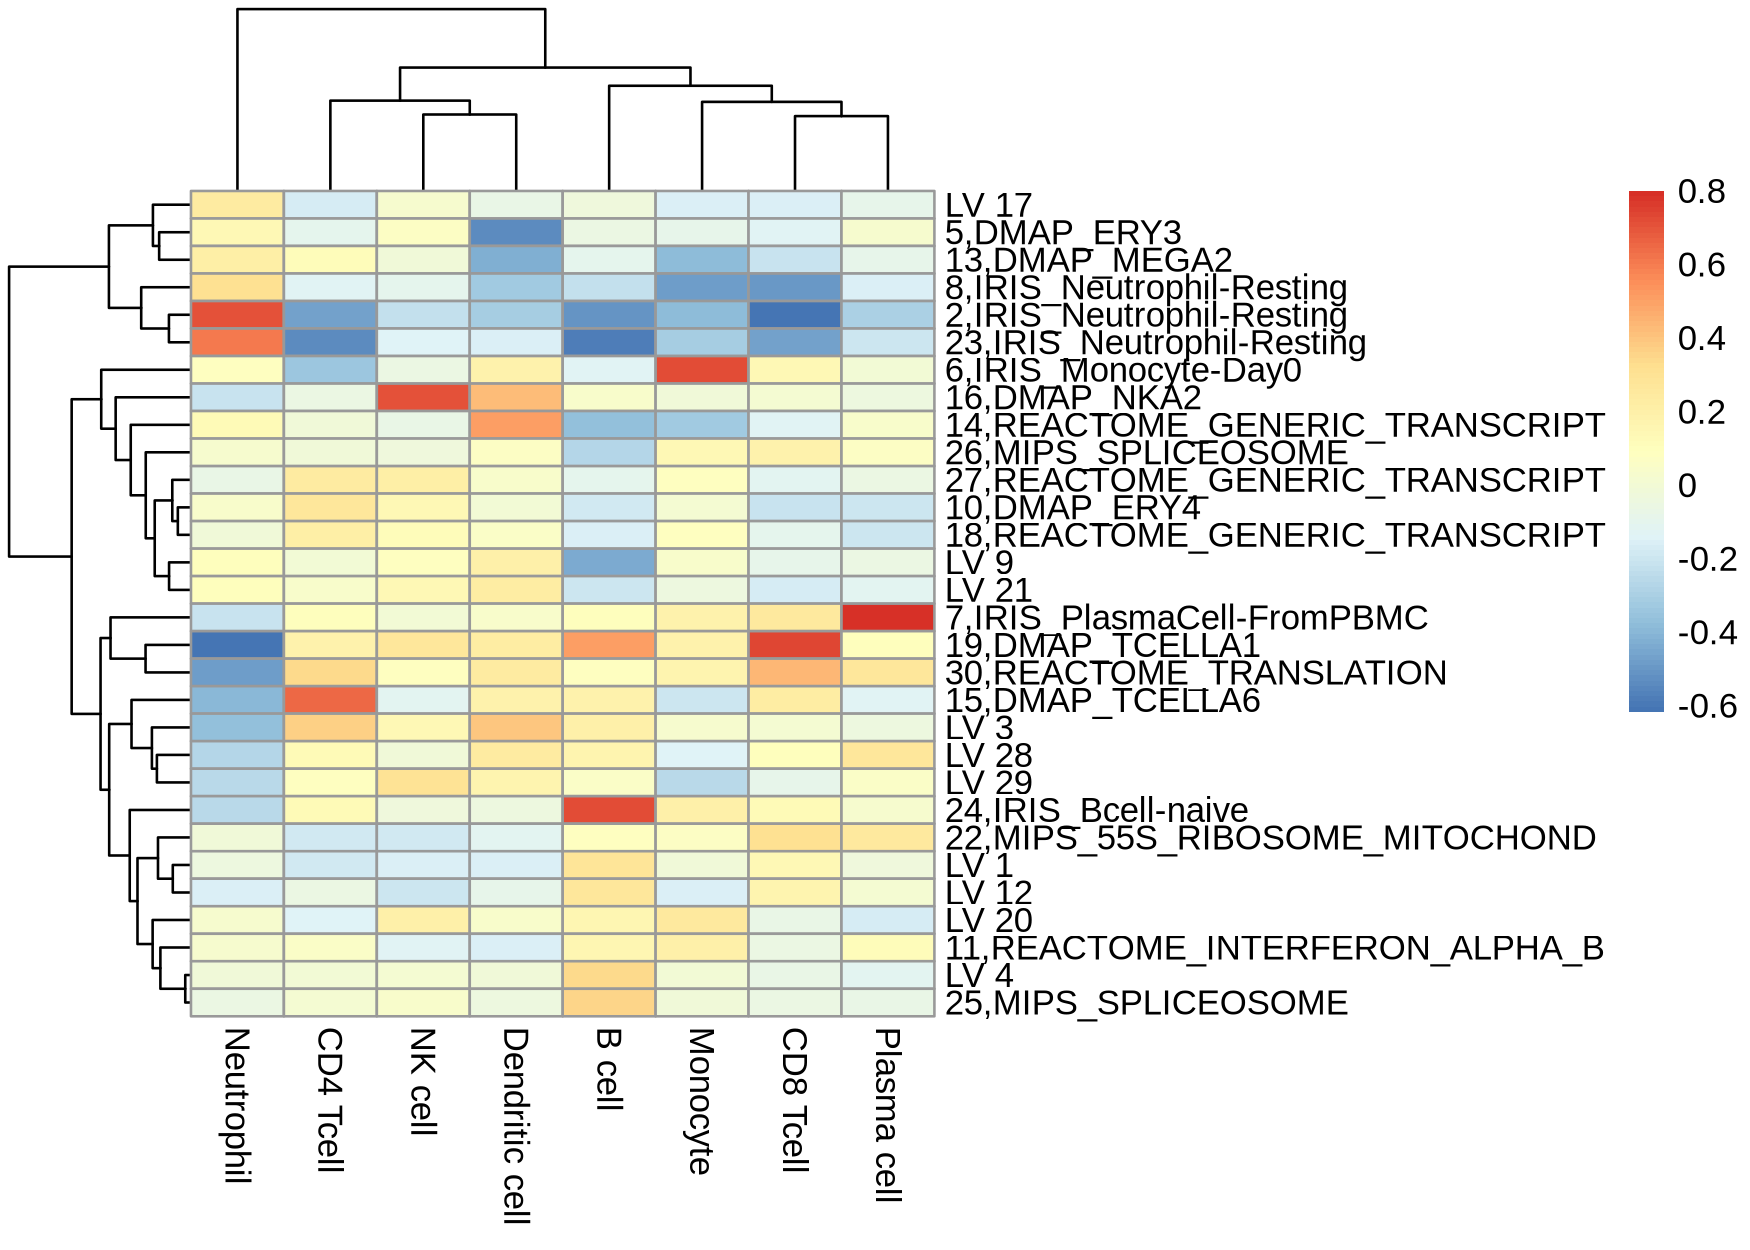

In [20]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 250)
# Load major cell types data
data(majorCellTypes)

# Compute correlation
corOut <- cor(t(as.matrix(delayedPlier_result$B)[, rownames(majorCellTypes)]), majorCellTypes, method = "s")
rownames(corOut) <- strtrim(rownames(corOut), 30)
pheatmap(corOut)

# PLIER dataWholeBlood

Selecting common genes: 5892

Removing 3 pathways with too few genes

Computing SVD

Done

k is set to 30



[1] 36.86117
[1] "L2 is set to 36.8611678671894"
[1] "L1 is set to 18.4305839335947"


errorY (SVD based:best possible) = 0.4971

New L3 is 0.000804733010124613

New L3 is 0.000488095243523415

New L3 is 0.000626726698448458

New L3 is 0.000488095243523415

New L3 is 0.000553084370147834

New L3 is 0.000488095243523415

New L3 is 0.000488095243523415

New L3 is 0.000488095243523415

New L3 is 0.000553084370147834

New L3 is 0.000488095243523415

New L3 is 0.000488095243523415

New L3 is 0.000430742540575688

New L3 is 0.000430742540575688

Bdiff is not decreasing

Bdiff is not decreasing

Bdiff is not decreasing

Bdiff is not decreasing

Bdiff is not decreasing

Bdiff is not decreasing

converged at  iteration 265 Bdiff is not decreasing

There are 13  LVs with AUC>0.70

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_win

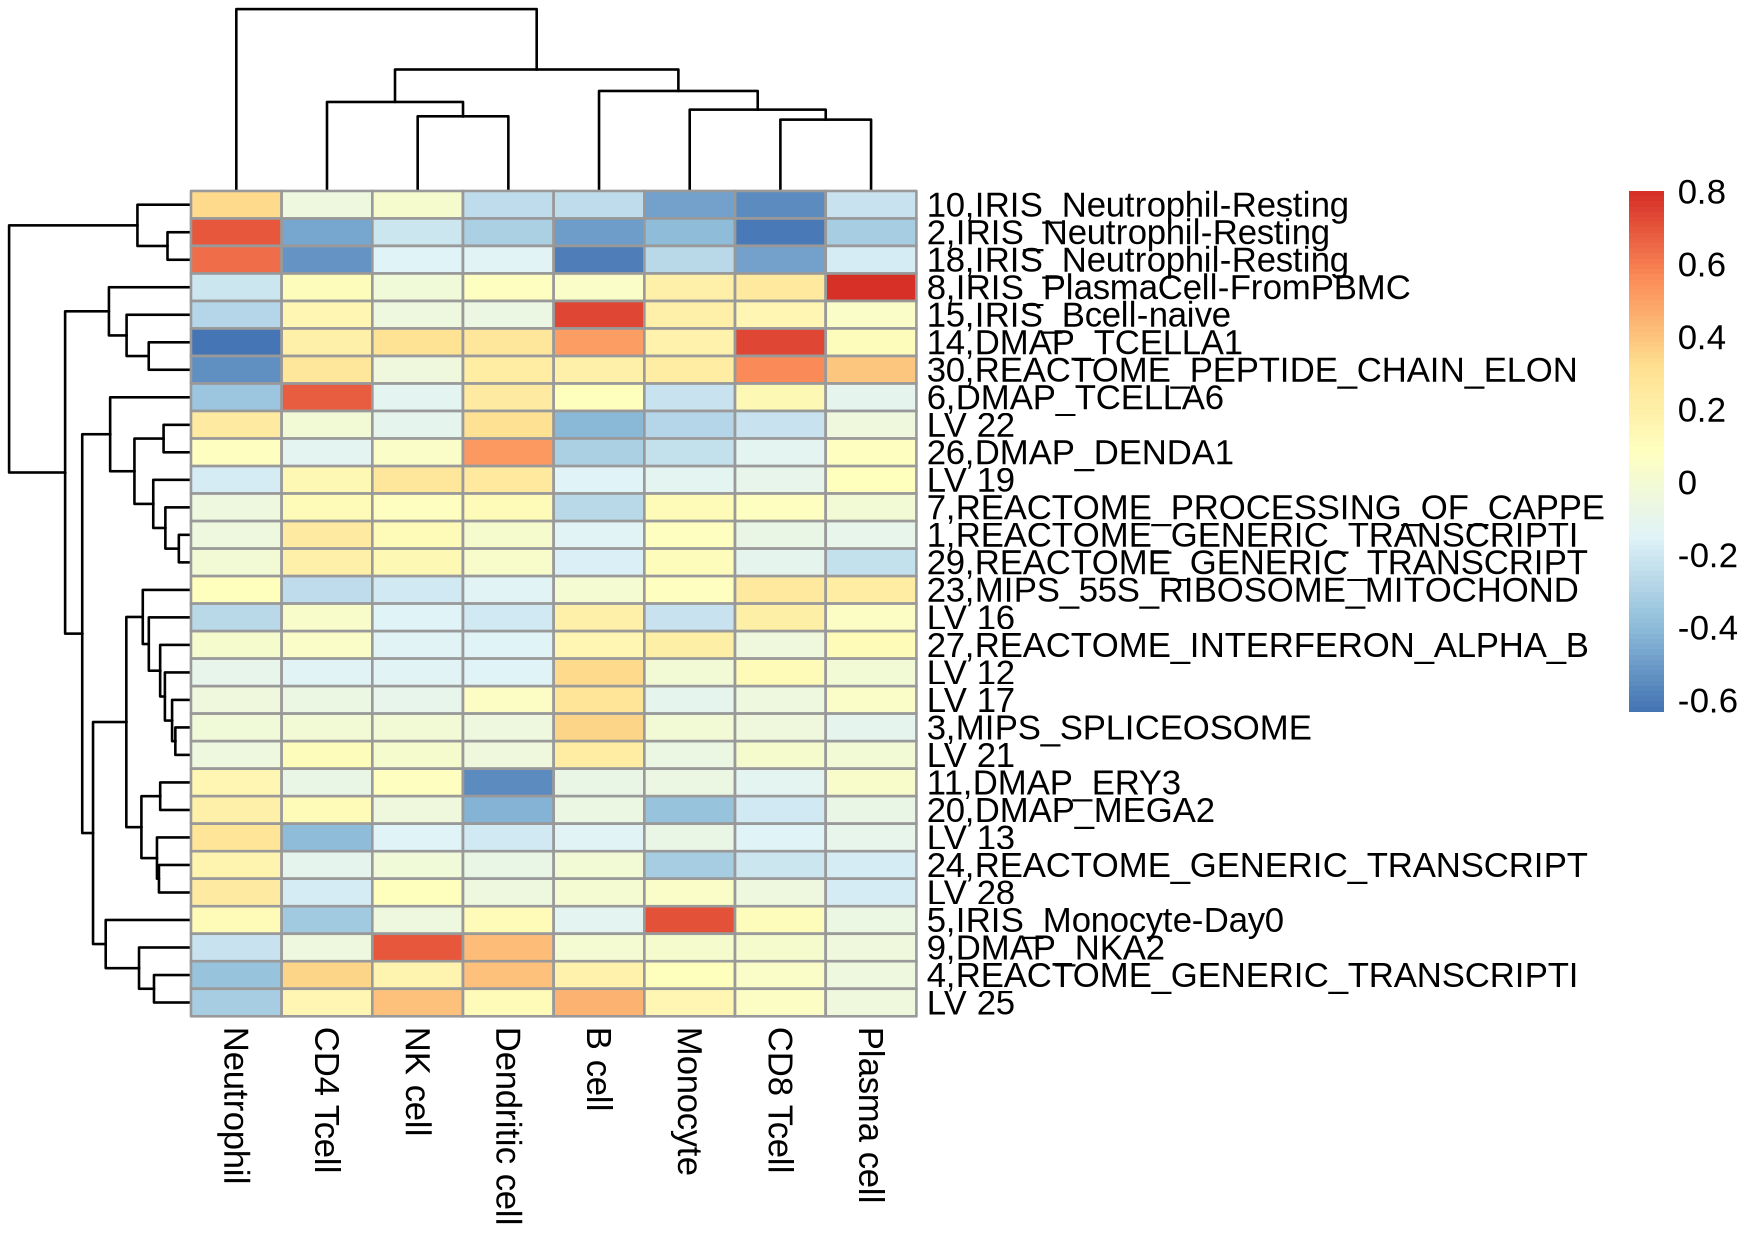

In [22]:
# Run PLIER with all default parameters
plierResult <- PLIER::PLIER(dataWholeBlood, allPaths)

# Output from PLIER
print(plierResult)

# Assign arguments to variables 
output_file_plier <- file.path(output_nb_path, 'plier_dataWholeBlood.rds')

# Prepare output directory
output_file_path=dirname(output_file_plier)
dir.create(dirname(output_file_plier), showWarnings = FALSE, recursive = TRUE)

# Save results
saveRDS(plierResult, file = output_file_plier)

# Output from PLIER
print(plierResult)
# Load major cell types data
data(majorCellTypes)

# Compute correlation
corOut <- cor(t(plierResult$B[, rownames(majorCellTypes)]), majorCellTypes, method = "s")
rownames(corOut) <- strtrim(rownames(corOut), 30)
pheatmap(corOut)

# delayedPLIER vacData

In [ ]:
# Additional steps for the Vaccination Dataset
# Load data
data(svmMarkers)
data(vacData)

# Construct a joint pathway matrix
allPaths <- combinePaths(bloodCellMarkersIRISDMAP, svmMarkers, canonicalPathways)
cm.genes <- commonRows(allPaths, vacData)

vacData <- vacData[cm.genes, ]
allPaths <- allPaths[cm.genes, ]

plierResult <- PLIER(vacData, allPaths)

# Visualize the U matrix with default cutoffs
plotU(plierResult, auc.cutoff = 0.70, fdr.cutoff = 0.05, top = 3)

# PLIER vacData


In [ ]:
# Additional steps for the Vaccination Dataset
# Load data
data(svmMarkers)
data(vacData)

# Construct a joint pathway matrix
allPaths <- combinePaths(bloodCellMarkersIRISDMAP, svmMarkers, canonicalPathways)
cm.genes <- commonRows(allPaths, vacData)

vacData <- vacData[cm.genes, ]
allPaths <- allPaths[cm.genes, ]

plierResult <- PLIER(vacData, allPaths)

# Visualize the U matrix with default cutoffs
plotU(plierResult, auc.cutoff = 0.70, fdr.cutoff = 0.05, top = 3)